In [46]:
from scipy import *
import numpy as np
from numpy.random import rand, uniform
import matplotlib.pyplot as plt
import matplotlib.animation
import PlanktonSignaling.basics as PS
import PlanktonSignaling.BlobDetection as BD
import PlanktonSignaling.Deposition as DP
import profile

%matplotlib notebook

#%load_ext Cython

Note here that $d_1 = \frac{\kappa \lambda_0}{v^2}$ and $d_2 = \frac{\beta}{\lambda_0}$. For the correct deposition functions, use linAtanDep2 and atanDep2 to include tanh.

In [47]:
meshsize = 100
numb = 24**2 #must be a perfect square.
LL = 10
Swimmers = PS.Plankton(DP.atanDep2,N = meshsize,depMaxStr=.01,Const=3,L=LL,k=0.02,epsilon=1e-3,speed=1,
             lambda0=1,kappa=.2,beta=5,depThreshold=0.05, depTransWidth=0.03, dens=6.476363593662468, num = numb)

def initial_conditions(x,y):
    return(0*x+0.012)

print(Swimmers.d1)
print(Swimmers.d2)

0.2
5.0


In [48]:
def Contour(pos):
    f = zeros((meshsize,meshsize))
    Std = Swimmers.L**2/Swimmers.num
    for i in range(0,Swimmers.num):
        A = 0
        B = 0
        C = 0 
        D = 0
        p = pos[i,:]
        f = f + (1/(4*pi*Std))*exp(-((Swimmers.xm-p[0])**2+(Swimmers.ym-p[1])**2)/4/Std)
        if ((p[0])**2<8*Std):
            f = f + (1/(4*pi*Std))*exp(-((Swimmers.xm-p[0]-Swimmers.L)**2+(Swimmers.ym-p[1])**2)/4/Std)
            A = 1
        if ((p[0]-Swimmers.L)**2<8*Std):
            f = f + (1/(4*pi*Std))*exp(-((Swimmers.xm-p[0]+Swimmers.L)**2+(Swimmers.ym-p[1])**2)/4/Std)
            B = 1
        if ((p[1])**2<8*Std):
            f = f + (1/(4*pi*Std))*exp(-((Swimmers.xm-p[0])**2+(Swimmers.ym-p[1]-Swimmers.L)**2)/4/Std)
            C = 1
        if ((p[1]-Swimmers.L)**2<8*Std):
            f = f + (1/(4*pi*Std))*exp(-((Swimmers.xm-p[0])**2+(Swimmers.ym-p[1]+Swimmers.L)**2)/4/Std)
            D = 1
        if (A == 1 and C == 1): #Plankton in Lower Left Corner
            f = f + (1/(4*pi*Std))*exp(-((Swimmers.xm-p[0]-Swimmers.L)**2+(Swimmers.ym-p[1]-Swimmers.L)**2)/4/Std)
        if (A == 1 and D == 1): #Plankton in Lower Left Corner
            f = f + (1/(4*pi*Std))*exp(-((Swimmers.xm-p[0]-Swimmers.L)**2+(Swimmers.ym-p[1]+Swimmers.L)**2)/4/Std)
        if (B == 1 and C == 1): #Plankton in Upper Right Corner
            f = f + (1/(4*pi*Std))*exp(-((Swimmers.xm-p[0]+Swimmers.L)**2+(Swimmers.ym-p[1]-Swimmers.L)**2)/4/Std)
        if (B == 1 and D == 1): #Plankton in Lower Right Corner
            f = f + (1/(4*pi*Std))*exp(-((Swimmers.xm-p[0]+Swimmers.L)**2+(Swimmers.ym-p[1]+Swimmers.L)**2)/4/Std)
    return(f*Swimmers.density*Swimmers.L**2/Swimmers.num)

<IPython.core.display.Javascript object>


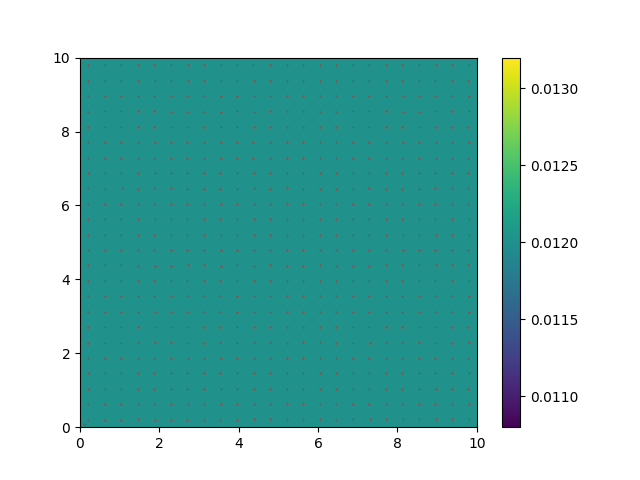

In [49]:
Swimmers.SetIC(initial_conditions)

pos = [array([0.1,0.1])]

aggreg = [array([0,0])]
areaAve = [array([0,0])]
lenn= int(sqrt(numb))
th = rand()*2*pi
vel = [array([cos(th),sin(th)])]

for l in range(0,lenn):
    for k in range(0,lenn):
        pos = np.append(pos,[array([mod(k*(Swimmers.L*1/lenn) + 0.01*(rand()-0.5) + 0.5*(Swimmers.L*1/lenn),Swimmers.L),
                                  mod(l*(Swimmers.L*1/lenn) + 0.01*(rand()-0.5) + 0.5*(Swimmers.L*1/lenn),Swimmers.L)])],axis=0)
        th  = rand()*2*pi
        vel = np.append(vel,[array([cos(th),sin(th)])],axis=0)

plt.figure()
plt.pcolormesh(Swimmers.xm,Swimmers.ym,Swimmers.Meshed())
plt.plot(pos[:,0],pos[:,1],'r.',MarkerSize=.5)
plt.colorbar()
plt.show()

In [54]:
time = 10

pos_store = list([pos[:,:]])
pos_store = list([np.array(pos)])

scalar_store = list([Swimmers.Meshed()])
aggreg = np.array([0,0])

count = 1
for plot in range(0,1):
    for k in range(0,time):
        Swimmers.Update(Swimmers.scalar,pos,vel)
        pos_store.append(np.array(pos))
        scalar_store.append(Swimmers.Meshed())
        
        #Counts the Number of Aggregations at time k
        
        #aggreg = np.vstack((aggreg,[k+1,BD.countingAll(1,255,BD.Contour(Swimmers,pos,400,meshsize))])) 
np.save('PlanktonPos',pos_store)
np.save('ChemStore',scalar_store)

In [55]:
ContoursAll = np.zeros((len(pos_store),meshsize,meshsize))
for k in range(0,len(scalar_store)):
    ContoursAll[k,:,:] = Contour(pos_store[k])
#np.save('Contours', ContoursAll)

# Animations

### Basic Animation with Chemical and Plankton Combined

In [ ]:
fig   = plt.figure()
ax    = plt.subplot(1,1,1)
pos_store2 = np.load('PlankDots.npy')
scalar_store2 = np.load('ChemStore.npy')
field = ax.pcolormesh(Swimmers.xm,Swimmers.ym,scalar_store2[0])
field.set_clim(0.01199,0.01201)
dots, = ax.plot([], [], 'r.',MarkerSize=.55)
fig.colorbar(field)

plt.suptitle(r'$d_1 = {0},d_2={1}$'.format(Swimmers.d1, Swimmers.d2), fontsize = 10)

def initit():
    dots.set_data([], [])
    return field,dots

def animate(k):
    arr = scalar_store2[k]
    arr = arr[:-1, :-1]
    field.set_array(arr.ravel())
    plt.title(r'Time = ${0}$'.format(k*Swimmers.k), fontsize = 20)
    dots.set_data(pos_store2[k][:,0],pos_store2[k][:,1])

    return dots,field
    
anim = matplotlib.animation.FuncAnimation(fig,animate,frames=range(0,2,1),
                                          interval=400,blit=False,repeat=False)

# Uncomment if you want to save it to a file.  Requires mencoder or ffmpeg or some writer utility to generate the file.
#anim.save('d102_d5_delta1e3_Atandep_HighDensity_scalingsmall3.mp4', writer='ffmpeg')
plt.show()

### Animation for Plankton Aggregation Contours

<IPython.core.display.Javascript object>


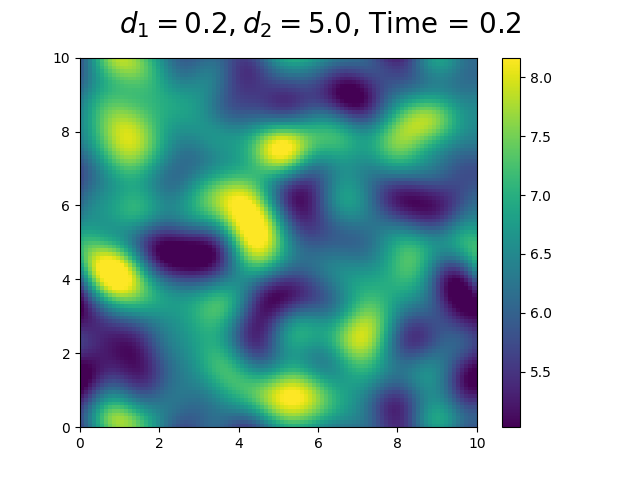

In [57]:
fig  = plt.figure()
#SA = (4*pi*Swimmers.L**2*Swimmers.density/Swimmers.num)**2/160000
#pos_store2 = np.load('PlankDots.npy')
#scalar_store2 = np.load('ChemStore.npy')
field1 = plt.pcolormesh(Swimmers.xm,Swimmers.ym,ContoursAll[0,:,:])
fig.colorbar(field1)
#field1.set_clim(0.00042,0.00058)

def initit():
    
    return field1

def animate(k):
    arr2 = ContoursAll[k,:,:]
    arr2 = arr2[:-1,:-1]
    field1.set_array(arr2.ravel())
    plt.suptitle(r'$d_1 = {0},d_2={1}$, Time = ${2}$'.format(Swimmers.d1, Swimmers.d2,round(k*Swimmers.k,2)), fontsize = 20)
    return field1,
    
anim = matplotlib.animation.FuncAnimation(fig,animate,frames=range(0,30,1),
                                          interval=80,blit=False,repeat=False)

# Uncomment if you want to save it to a file.  Requires mencoder or ffmpeg or some writer utility to generate the file.
#anim.save('d102_d5_delta1e3_Atandep_Contours.mp4', writer='ffmpeg')
plt.show()

### Animation for finding the most unstable wave numbers using a 2D Fast Fourier Transform

In [ ]:
fig   = plt.figure()
cmap = plt.get_cmap('binary')
freq = (len(Swimmers.xm)*2*pi/(Swimmers.L))*fftfreq(len(Swimmers.xm))
ax    = plt.subplot(1,1,1)
omega = np.fft.fft2(scalar_store[0])
field = ax.pcolormesh(np.fft.fftshift(freq),np.fft.fftshift(freq),log(abs(np.fft.fftshift(omega))),cmap=cmap)
flat=log(abs(fftshift(omega))).flatten()
flat.sort()
field.set_clim(flat[-2]-.1,flat[-2])
ax.set_ylim(-10,10)
ax.set_xlim(-10,10)
def xy(r,phi):
    return r*np.cos(phi), r*np.sin(phi)

phis=np.arange(0,6.28,0.01)

#Input the norm of the most unstable wave number using the stability code
r = 5.44
ax.plot( *xy(r,phis), c='r',ls='-' )

fig.colorbar(field)

plt.suptitle(r'$d_1 = {0},d_2={1}$'.format(Swimmers.d1, Swimmers.d2), fontsize = 10)

def initit():
    return field

def animate(k):
    omega = fft2(scalar_store[k])
    arr = log(abs(fftshift(omega)))
    arr = arr[:-1, :-1]
    field.set_array(arr.ravel())
    flat=log(abs(fftshift(omega))).flatten()
    flat.sort()
    field.set_clim(flat[-2]-.21,flat[-2])
    plt.title(r'T = {0}'.format(round(k*Swimmers.k,2)), fontsize = 15)
    
    return field
    
anim = matplotlib.animation.FuncAnimation(fig,animate,frames=range(0,len(scalar_store),1),
                                          interval=200,blit=False,repeat=False)

# Uncomment if you want to save it to a file.  Requires mencoder or ffmpeg or some writer utility to generate the file.
#anim.save('High_Wave_NumberAnim_d102_d250_Slow.mp4', writer='ffmpeg')
plt.show()